In [1]:
from collections import defaultdict
from datetime import datetime, date
import math
import os
import warnings

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from statsmodels.nonparametric.smoothers_lowess import lowess

from qaoa_solver import QAOASolver
from utils import int_to_binary_str, compute_solution, compute_fidelity


pd.set_option('display.max_columns', None)

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
DEFAULT_ANGLE = 1.047 # π/3

experiment_names = os.listdir('experiments/results')
experiment_names = [name for name in experiment_names if not name.startswith('test')]
experiment_results = []

for experiment in experiment_names:

    experiment_result_files = os.listdir(f'experiments/results/{experiment}')
    
    for result_file in experiment_result_files:
        result_date = datetime.strptime(result_file.split('_')[-1].split('.json')[0], '%Y%m%d%H%M%S%f').date()
        result = pd.read_json(f'experiments/results/{experiment}/{result_file}',lines=True)
        result['date'] = result_date
        experiment_results.append(result)


experiment_results = pd.concat(experiment_results)
experiment_results['num_qubits'] = experiment_results['nx'] + experiment_results['ny']
experiment_results['optimizer'] = experiment_results['config'].apply(lambda c: c.get('optimizer'))
experiment_results['problem_hamiltonian'] = experiment_results['config'].apply(lambda c: c.get('problem_hamiltonian'))
experiment_results['cost_hamiltonian'] = experiment_results['config'].apply(lambda c: c.get('cost_hamiltonian'))
experiment_results['gamma_0'] = experiment_results['config'].apply(lambda c: c.get('initial_gamma'))
experiment_results['beta_0'] = experiment_results['config'].apply(lambda c: c.get('initial_beta'))
experiment_results['experiment'] = experiment_results['config'].apply(lambda c: c.get('experiment'))
experiment_results['extended_qaoa'] = experiment_results['config'].apply(lambda c: c.get('extended_qaoa', False))
experiment_results['max_layers'] = experiment_results['config'].apply(lambda c: c.get('layers'))
experiment_results['commit_date'] = pd.to_datetime(experiment_results['config'].apply(lambda c: c.get('commit_date')))
experiment_results['setup'] = experiment_results['experiment'].str.split('_').str[1:].str.join('_')
experiment_results['state_populations'] = experiment_results['state'].apply(lambda s: [abs(complex(c))**2 for c in s])
experiment_results['solution'] = experiment_results.apply(lambda row: compute_solution(row['N']), axis=1)
experiment_results['fidelity'] = experiment_results.apply(lambda row: compute_fidelity(row['state_populations'], row['solution']), axis=1)
experiment_results['gamma_0'] = experiment_results['gamma_0'].round(3)
experiment_results['beta_0'] = experiment_results['beta_0'].round(3)
experiment_results['angle_interpolation'] = experiment_results['commit_date'] >= datetime(2025,6,10)

experiment_results = experiment_results[
    (experiment_results['angle_interpolation']==True)
    & (experiment_results['extended_qaoa']==False)
]

In [3]:
dup_subset = ['experiment', 'layers', 'optimizer', 'gamma_0', 'beta_0', 'cost', 'angle_interpolation']

dups = experiment_results[dup_subset]
dups = dups.groupby(dups.columns.tolist(),as_index=False).size().sort_values('size', ascending=False)
dups = dups[dups['size']>1]

if not dups.empty:
    print('Duplicates found!')
    display(dups[['experiment', 'optimizer', 'gamma_0', 'beta_0', 'angle_interpolation']].drop_duplicates().head())

experiment_results = experiment_results.drop_duplicates(subset=dup_subset).reset_index(drop=True)

In [4]:
plot_colors = [
    #[Dark ,    light]
    ["black",   "#A0A0A0"],  # Black
    ["#004C99", "#99CCFF"],  # Blue
    ["#990000", "#FF9999"],  # Red
    ["#006633", "#CCFFCC"],  # Green
    ["#cc4c02", "#fe9929"],  # Orange
    ["#91003f", "#c994c7"],  # Purple
    ["#8c510a", "#d8b365"],  # Brown
    ["#0868ac", "#43a2ca"],  # Cian
    ["#b8860b", "#ffd700"],  # Golden
]

In [5]:
Ns = sorted(experiment_results.N.unique())
optimizers = sorted(experiment_results.optimizer.unique())
setups = sorted(experiment_results.setup.unique(), reverse=True)

In [6]:
group_cols = ['N', 'setup', 'optimizer', 'layers']

experiment_results_agg = (
    experiment_results
        .groupby(group_cols)
        .agg({
            'num_qubits': 'first',
            'N': 'count',
            'cost': ['mean', 'median', 'std', 'max', 'min'],
            'fidelity': ['mean', 'median', 'std', 'max', 'min'],
            'optimizer_time': ['mean', 'median', 'std', 'max', 'min'],
            'state_populations': lambda x: np.sum(x.tolist(), axis=0).tolist()
        })
    )

experiment_results_agg.columns = ['_'.join(map(str, col)) for col in experiment_results_agg.columns.to_flat_index()]
experiment_results_agg = experiment_results_agg.rename(columns={'num_qubits_first': 'num_qubits'})
experiment_results_agg = experiment_results_agg.rename(columns={'state_populations_<lambda>': 'populations'})
experiment_results_agg = experiment_results_agg.rename(columns={'N_count': 'count'})

experiment_results_agg['populations_mean'] = experiment_results_agg.apply(lambda row: np.array(row['populations'])/row['count'], axis=1)
experiment_results_agg = experiment_results_agg.drop(columns='populations')

# Get the id where cost is minimum for each group
idx_min = experiment_results.groupby(group_cols)['cost'].idxmin()
best_populations = experiment_results.loc[idx_min, group_cols + ['state_populations']]
best_populations = best_populations.rename(columns={'state_populations': 'best_populations'})

# Merge the best_id into the aggregated DataFrame
experiment_results_agg = experiment_results_agg.merge(best_populations, on=group_cols, how='left')


experiment_results_agg = experiment_results_agg.sort_values(['N', 'optimizer', 'setup', 'layers'])
experiment_results_agg = experiment_results_agg.reset_index(drop=True)

# experiment_results_agg['infidelity_mean'] = 1 - experiment_results_agg['fidelity_mean']
# experiment_results_agg['infidelity_median'] = 1 - experiment_results_agg['fidelity_median']
# experiment_results_agg['infidelity_min'] = 1 - experiment_results_agg['fidelity_max']
# experiment_results_agg['infidelity_max'] = 1 - experiment_results_agg['fidelity_min']

# experiments_df = pd.merge(experiment_configs, experiment_results_agg, how='inner', on='experiment')

# if (experiments_df['num_gates_std'] != 0).any():
#     print('Warning: There are experiments with inconsistent number of gates')

## Comparison between optimizers

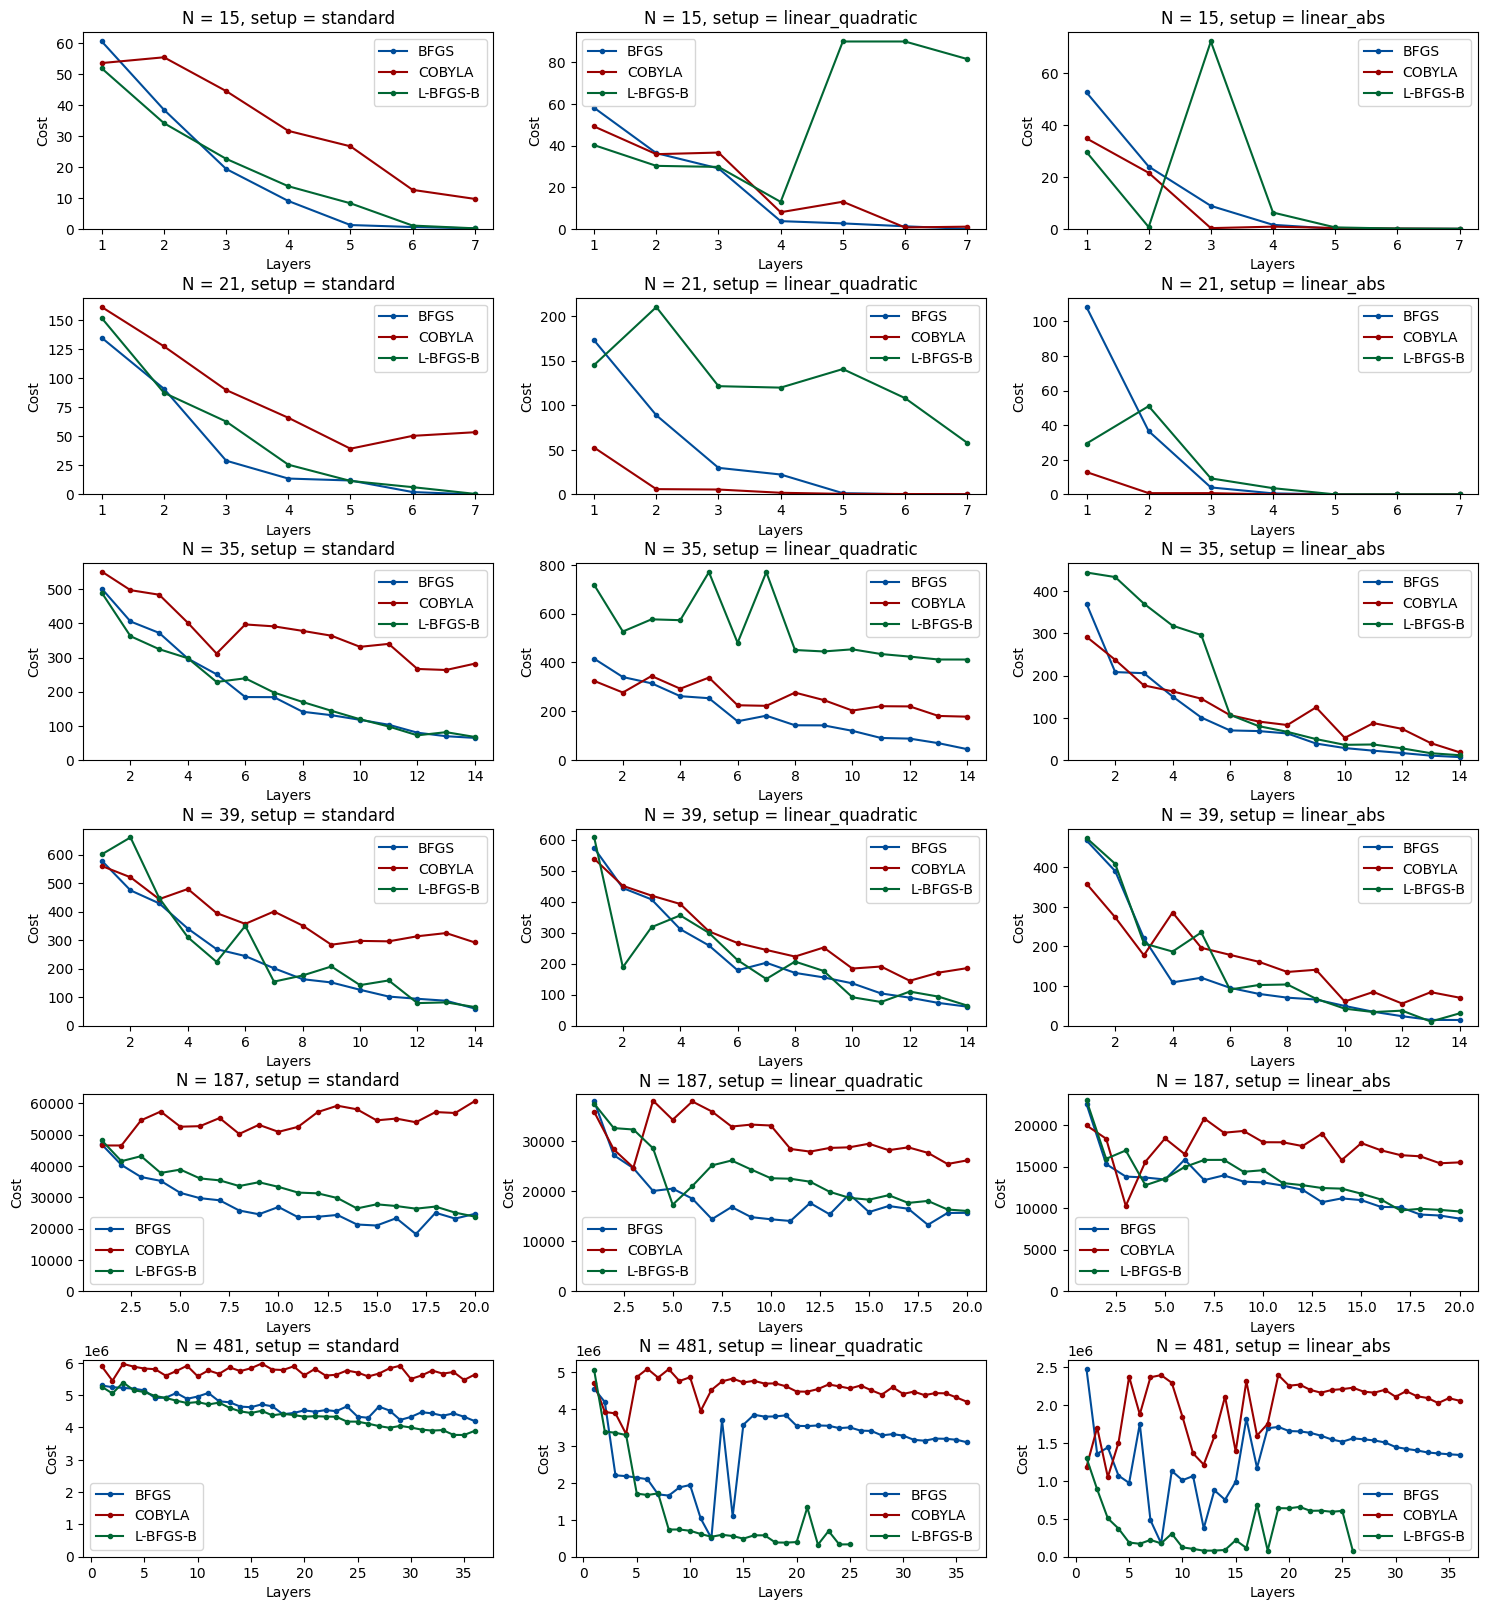

In [7]:
fig, axs = plt.subplots(len(Ns), len(setups), figsize=(6*len(setups), 3.3*len(Ns)))
fig.subplots_adjust(hspace=0.35, wspace=0.2)

for i, N in enumerate(Ns):
    df_N = experiment_results_agg[(experiment_results_agg.N == N)]
    for k, setup in enumerate(setups):
        for j, optimizer in enumerate(optimizers):
            df = df_N[(df_N.setup == setup) & (df_N.optimizer == optimizer)].copy()
            if setup == 'linear_abs':
                df['cost_median'] = np.power(df['cost_median'], 2)
            axs[i,k].plot('layers', 'cost_median', data=df, marker='.', color=plot_colors[j+1][0], label=optimizer)

        axs[i,k].set_ylabel('Cost')
        axs[i,k].set_title(f'N = {N}, setup = {setup}')
        axs[i,k].set_xlabel('Layers')
        axs[i,k].set_ylim(0)

        axs[i,k].legend(loc='best')

fig_name = f'plots/methods_comparison.pdf'
plt.savefig(fig_name, bbox_inches='tight')


## Comparison between setups for BFGS

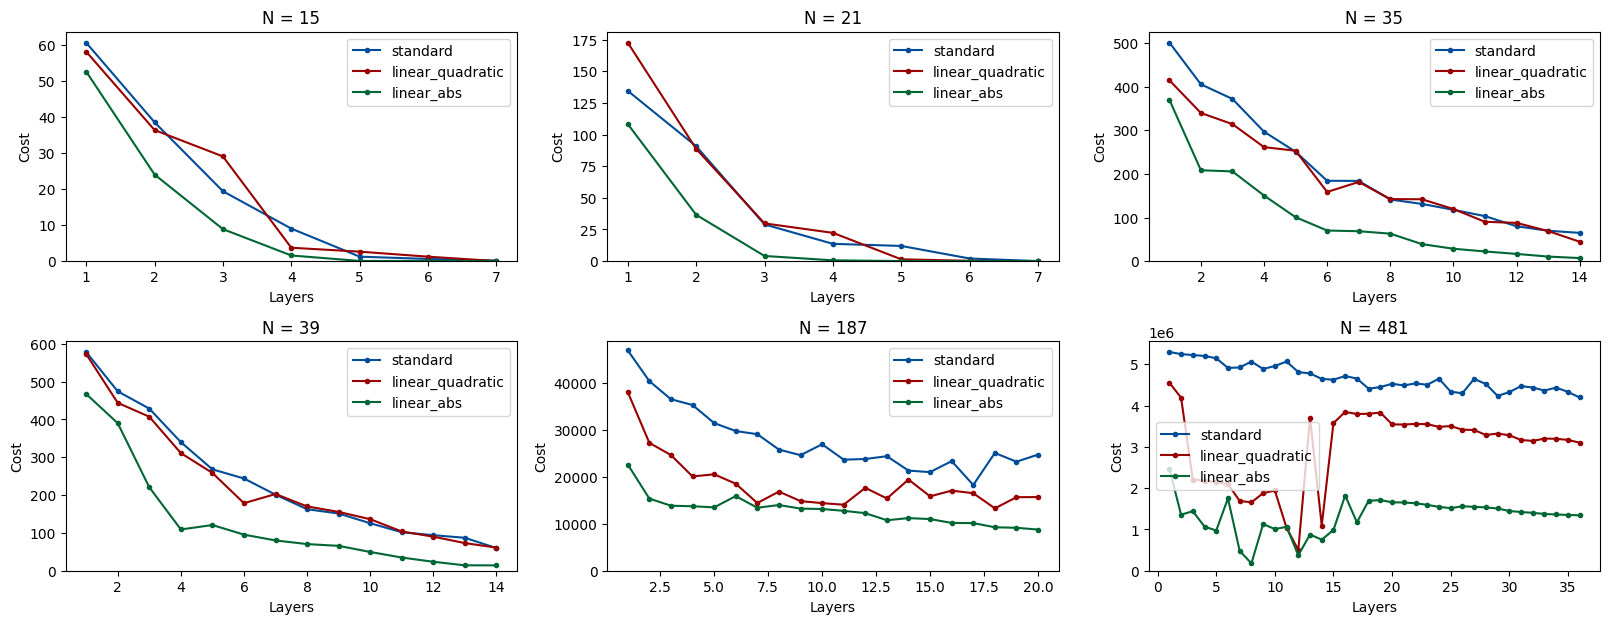

In [8]:
fig, axs = plt.subplots(math.ceil(len(Ns)/3), 3, figsize=(3.3*len(Ns), 7))
fig.subplots_adjust(hspace=0.35, wspace=0.2)

axs = axs.flatten()

for i, N in enumerate(Ns):
    df_N = experiment_results_agg[(experiment_results_agg.N == N) & (experiment_results_agg.optimizer == 'BFGS')]
    for j, setup in enumerate(setups):
        df = df_N[df_N.setup == setup].copy()
        if setup == 'linear_abs':
            df['cost_median'] = np.power(df['cost_median'], 2)
        axs[i].plot('layers', 'cost_median', data=df, marker='.', color=plot_colors[j+1][0], label=setup)

    axs[i].set_ylabel('Cost')
    axs[i].set_title(f'N = {N}')
    axs[i].set_xlabel('Layers')
    axs[i].set_ylim(0)

    axs[i].legend(loc='best');

fig_name = f'plots/setups_comparison.pdf'
plt.savefig(fig_name, bbox_inches='tight')


## Comparison between setups for L-BFGS-B

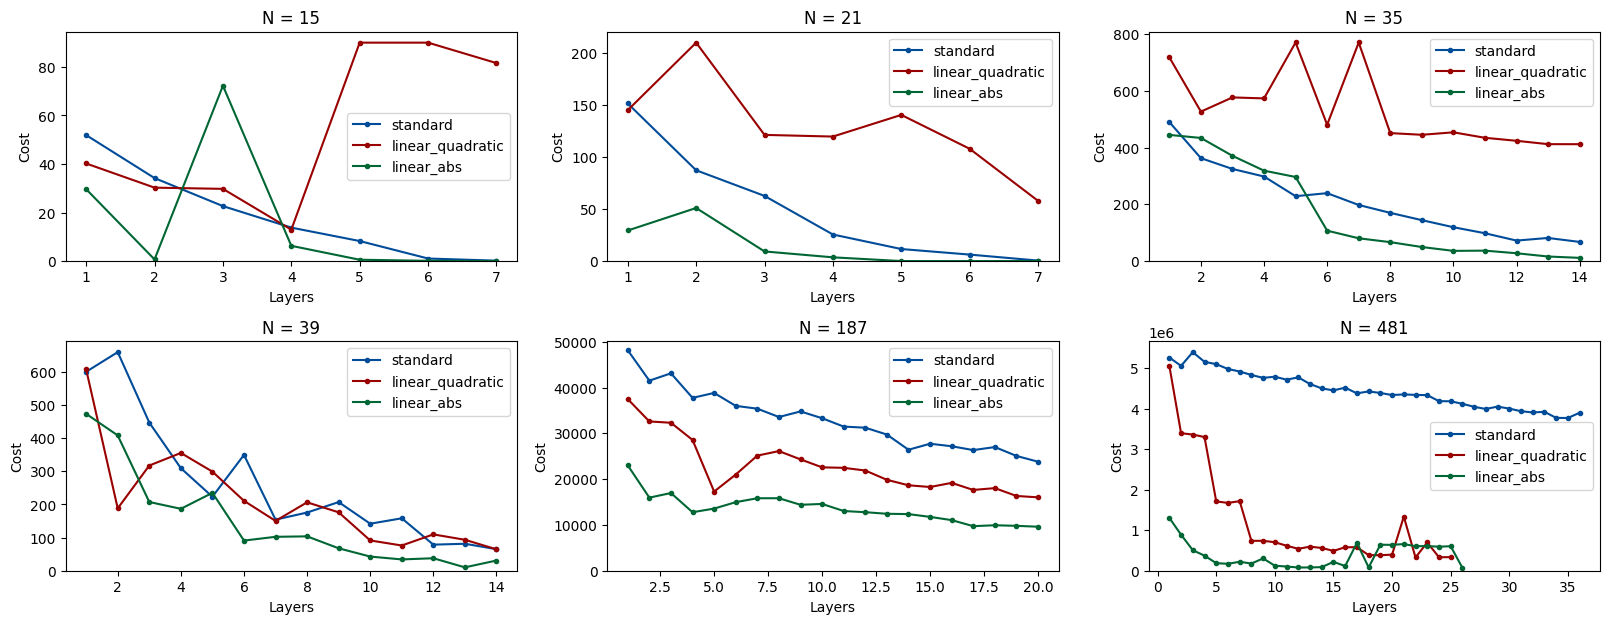

In [9]:
fig, axs = plt.subplots(math.ceil(len(Ns)/3), 3, figsize=(3.3*len(Ns), 7))
fig.subplots_adjust(hspace=0.35, wspace=0.2)

axs = axs.flatten()

for i, N in enumerate(Ns):
    df_N = experiment_results_agg[(experiment_results_agg.N == N) & (experiment_results_agg.optimizer == 'L-BFGS-B')]
    for j, setup in enumerate(setups):
        df = df_N[df_N.setup == setup].copy()
        if setup == 'linear_abs':
            df['cost_median'] = np.power(df['cost_median'], 2)
        axs[i].plot('layers', 'cost_median', data=df, marker='.', color=plot_colors[j+1][0], label=setup)

    axs[i].set_ylabel('Cost')
    axs[i].set_title(f'N = {N}')
    axs[i].set_xlabel('Layers')
    axs[i].set_ylim(0)

    axs[i].legend(loc='best');

fig_name = f'plots/setups_comparison.pdf'
plt.savefig(fig_name, bbox_inches='tight')


## Average Populations

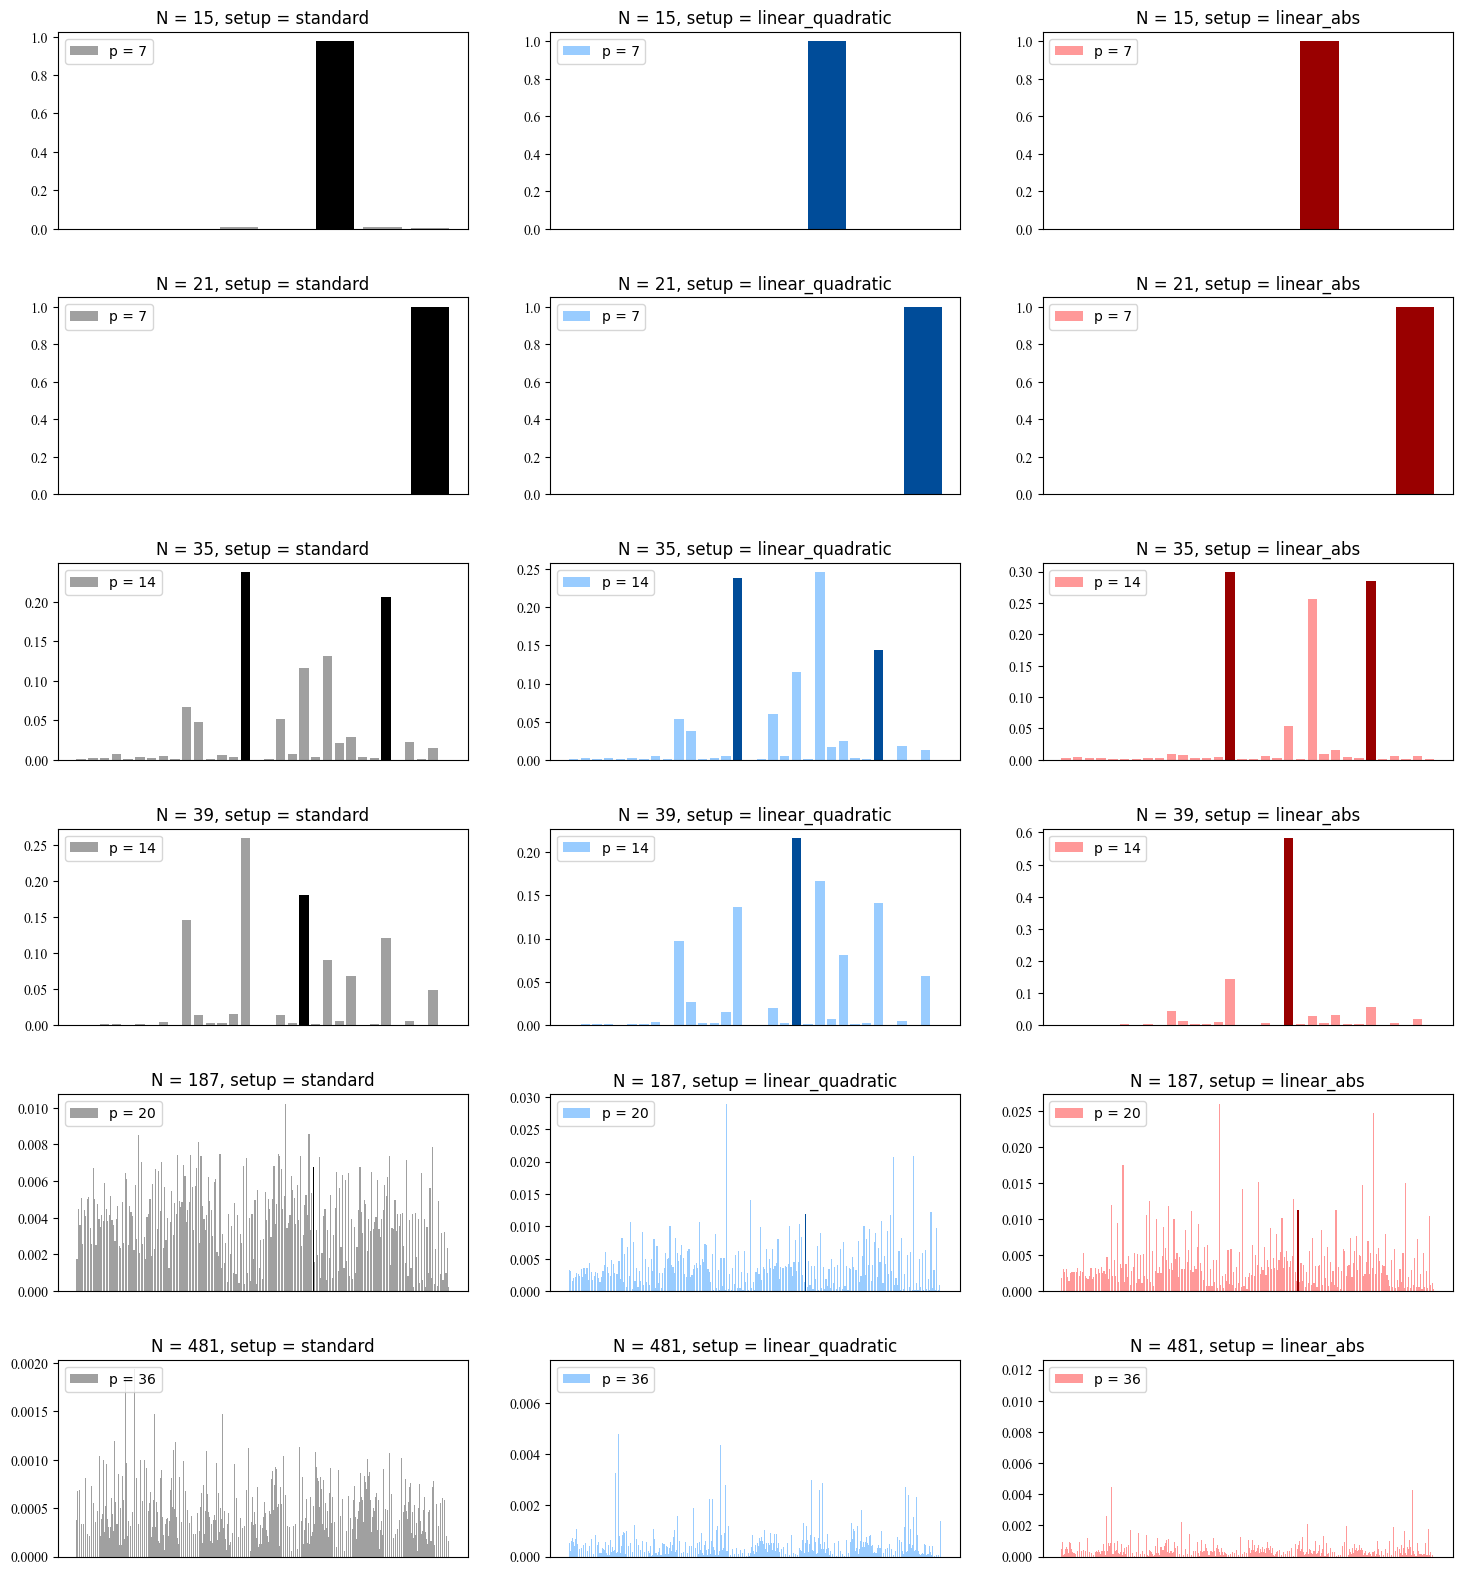

In [10]:
fig, axs = plt.subplots(len(Ns), len(setups), figsize=(6*len(setups), 3.3*len(Ns)))
fig.subplots_adjust(hspace=0.35, wspace=0.2)

for i, N in enumerate(Ns):
    df_N = experiment_results_agg[(experiment_results_agg.N == N) & (experiment_results_agg.optimizer == 'BFGS')].reset_index(drop=True)
    num_qubits = df_N.loc[0, 'num_qubits']
    solutions = compute_solution(N)
    x_hist = [int_to_binary_str(n, num_qubits) for n in range(2**num_qubits)]

    max_layers = df_N['layers'].max()

    for j, setup in enumerate(setups):

        df_N_setup = df_N[(df_N['setup']==setup)]
        max_layers = df_N_setup['layers'].max()
        df =  df_N_setup[df_N_setup['layers']==max_layers].reset_index(drop=True).loc[0, 'populations_mean']

        bar_colors = [plot_colors[j][0] if c in solutions else plot_colors[j][1] for c in x_hist]

        axs[i][j].bar(x_hist, df, label=f'p = {max_layers}', color=bar_colors)
        axs[i][j].set_ylim(0)

        labels = (axs[i][j].get_xticklabels() + axs[i][j].get_yticklabels())

        for label in labels:
            label.set_fontname('Times New Roman')

        axs[i][j].legend(loc='upper left')
        axs[i][j].set_xticks(range(2**num_qubits), "")
        axs[i][j].xaxis.set_major_locator(ticker.NullLocator())
        axs[i][j].set_title(f'N = {N}, setup = {setup}')

fig_name = f'plots/analysis_populations.pdf'
plt.savefig(fig_name, bbox_inches='tight')

## Best results

### By cost

In [11]:
group_cols = ['N', 'setup']

# Get the id where cost is minimum for each group
idx_min = experiment_results.groupby(group_cols)['cost'].idxmin()
best_results = experiment_results.loc[idx_min,]

best_results = best_results[['N', 'setup', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'state_populations', 'fidelity', 'cost', 'num_qubits']].reset_index(drop=True)

best_results

,N,setup,optimizer,layers,gamma_0,beta_0,state_populations,fidelity,cost,num_qubits
0,15,linear_abs,L-BFGS-B,7,3.428,1.861,"[2.2213940169317707e-10, 8.107282754043833e-10...",1.000000,8.662975e-08,3
1,15,linear_quadratic,L-BFGS-B,5,2.694,2.320,"[4.931016681837994e-12, 3.185194795596947e-12,...",1.000000,1.856609e-09,3
2,15,standard,BFGS,7,3.053,1.152,"[7.895131448234326e-15, 2.9922729391870412e-15...",1.000000,1.317679e-11,3
3,21,linear_abs,L-BFGS-B,7,2.694,2.320,"[2.2997235619669462e-11, 8.475137963020268e-11...",1.000000,1.050581e-08,3
4,21,linear_quadratic,BFGS,7,3.061,1.897,"[1.2884092325239485e-12, 4.940020124716064e-13...",1.000000,1.628092e-09,3
5,21,standard,BFGS,7,1.896,1.101,"[2.8763573830007438e-15, 2.9647716442466973e-1...",1.000000,7.790895e-12,3
6,35,linear_abs,BFGS,14,2.984,0.901,"[0.0003882041254432592, 0.00035410907959226737...",0.979980,3.676379e-01,5
7,35,linear_quadratic,BFGS,9,3.038,1.432,"[0.0003337168736033215, 0.0006909450384089343,...",0.847784,3.169192e+01,5
8,35,standard,BFGS,14,3.273,1.298,"[0.0005235734089477448, 0.0027202082445040836,...",0.518570,3.322960e+01,5
9,39,linear_abs,BFGS,13,1.901,0.926,"[0.0005605698230224867, 0.00022994575627501078...",0.942966,6.583005e-01,5


### By fidelity

In [27]:
idx_min = experiment_results.groupby(group_cols)['fidelity'].idxmax()
best_results = experiment_results.loc[idx_min,]

best_results = best_results[['N', 'setup', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'state_populations', 'fidelity', 'cost', 'num_qubits']].reset_index(drop=True)

best_results

,N,setup,optimizer,layers,gamma_0,beta_0,state_populations,fidelity,cost,num_qubits
0,15,linear_abs,L-BFGS-B,7,3.428,1.861,"[2.2213940169317707e-10, 8.107282754043833e-10...",1.000000,8.662975e-08,3
1,15,linear_quadratic,L-BFGS-B,5,2.694,2.320,"[4.931016681837994e-12, 3.185194795596947e-12,...",1.000000,1.856609e-09,3
2,15,standard,BFGS,7,3.053,1.152,"[7.895131448234326e-15, 2.9922729391870412e-15...",1.000000,1.317679e-11,3
3,21,linear_abs,L-BFGS-B,7,2.694,2.320,"[2.2997235619669462e-11, 8.475137963020268e-11...",1.000000,1.050581e-08,3
4,21,linear_quadratic,BFGS,7,3.061,1.897,"[1.2884092325239485e-12, 4.940020124716064e-13...",1.000000,1.628092e-09,3
5,21,standard,BFGS,7,2.073,2.278,"[6.869179994821649e-15, 1.5899680808483635e-14...",1.000000,1.120620e-11,3
6,35,linear_abs,BFGS,14,2.984,0.901,"[0.0003882041254432592, 0.00035410907959226737...",0.979980,3.676379e-01,5
7,35,linear_quadratic,BFGS,9,4.050,0.902,"[0.0003337186791980223, 0.0006909475733505251,...",0.847784,3.169192e+01,5
8,35,standard,BFGS,14,1.047,1.047,"[0.0009099952564454205, 0.004593977470357765, ...",0.657452,8.509635e+01,5
9,39,linear_abs,BFGS,13,1.901,0.926,"[0.0005605698230224867, 0.00022994575627501078...",0.942966,6.583005e-01,5


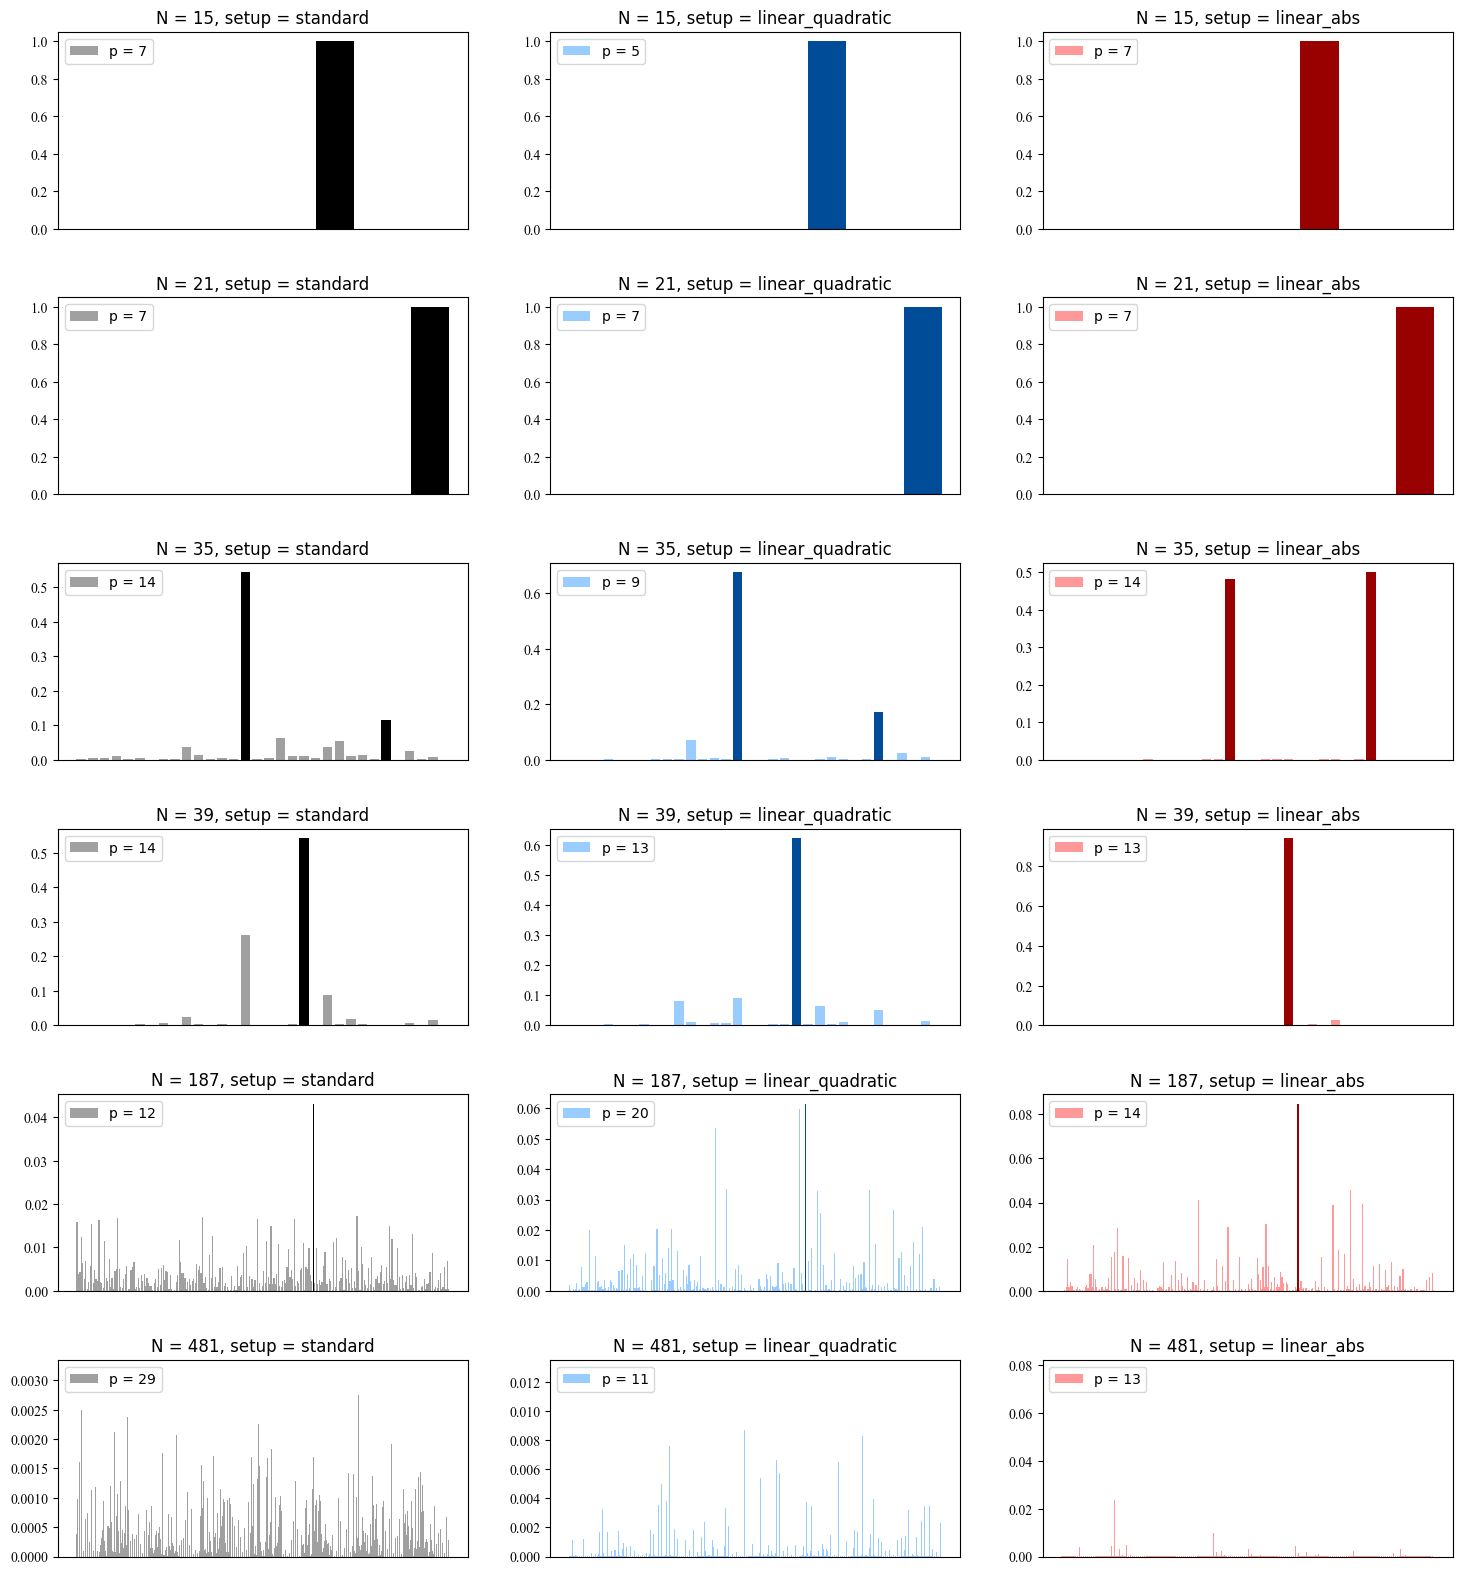

In [13]:
Ns = sorted(best_results.N.unique())
setups = sorted(best_results.setup.unique(), reverse=True)

fig, axs = plt.subplots(len(Ns), len(setups), figsize=(6*len(setups), 3.3*len(Ns)))
fig.subplots_adjust(hspace=0.35, wspace=0.2)

for i, N in enumerate(Ns):
    df_N = best_results[(best_results.N == N)].reset_index(drop=True)
    num_qubits = df_N.loc[0, 'num_qubits']
    solutions = compute_solution(N)
    x_hist = [int_to_binary_str(n, num_qubits) for n in range(2**num_qubits)]

    for j, setup in enumerate(setups):
        df_N_setup = df_N[(df_N['setup']==setup)].reset_index(drop=True)
        layers = df_N_setup.loc[0, 'layers']
        df =  df_N_setup.loc[0, 'state_populations']

        bar_colors = [plot_colors[j][0] if c in solutions else plot_colors[j][1] for c in x_hist]

        axs[i][j].bar(x_hist, df, label=f'p = {layers}', color=bar_colors)
        axs[i][j].set_ylim(0)

        labels = (axs[i][j].get_xticklabels() + axs[i][j].get_yticklabels())

        for label in labels:
            label.set_fontname('Times New Roman')

        axs[i][j].legend(loc='upper left')
        axs[i][j].set_xticks(range(2**num_qubits), "")
        axs[i][j].xaxis.set_major_locator(ticker.NullLocator())
        axs[i][j].set_title(f'N = {N}, setup = {setup}')

## Cost-Fidelity correlations

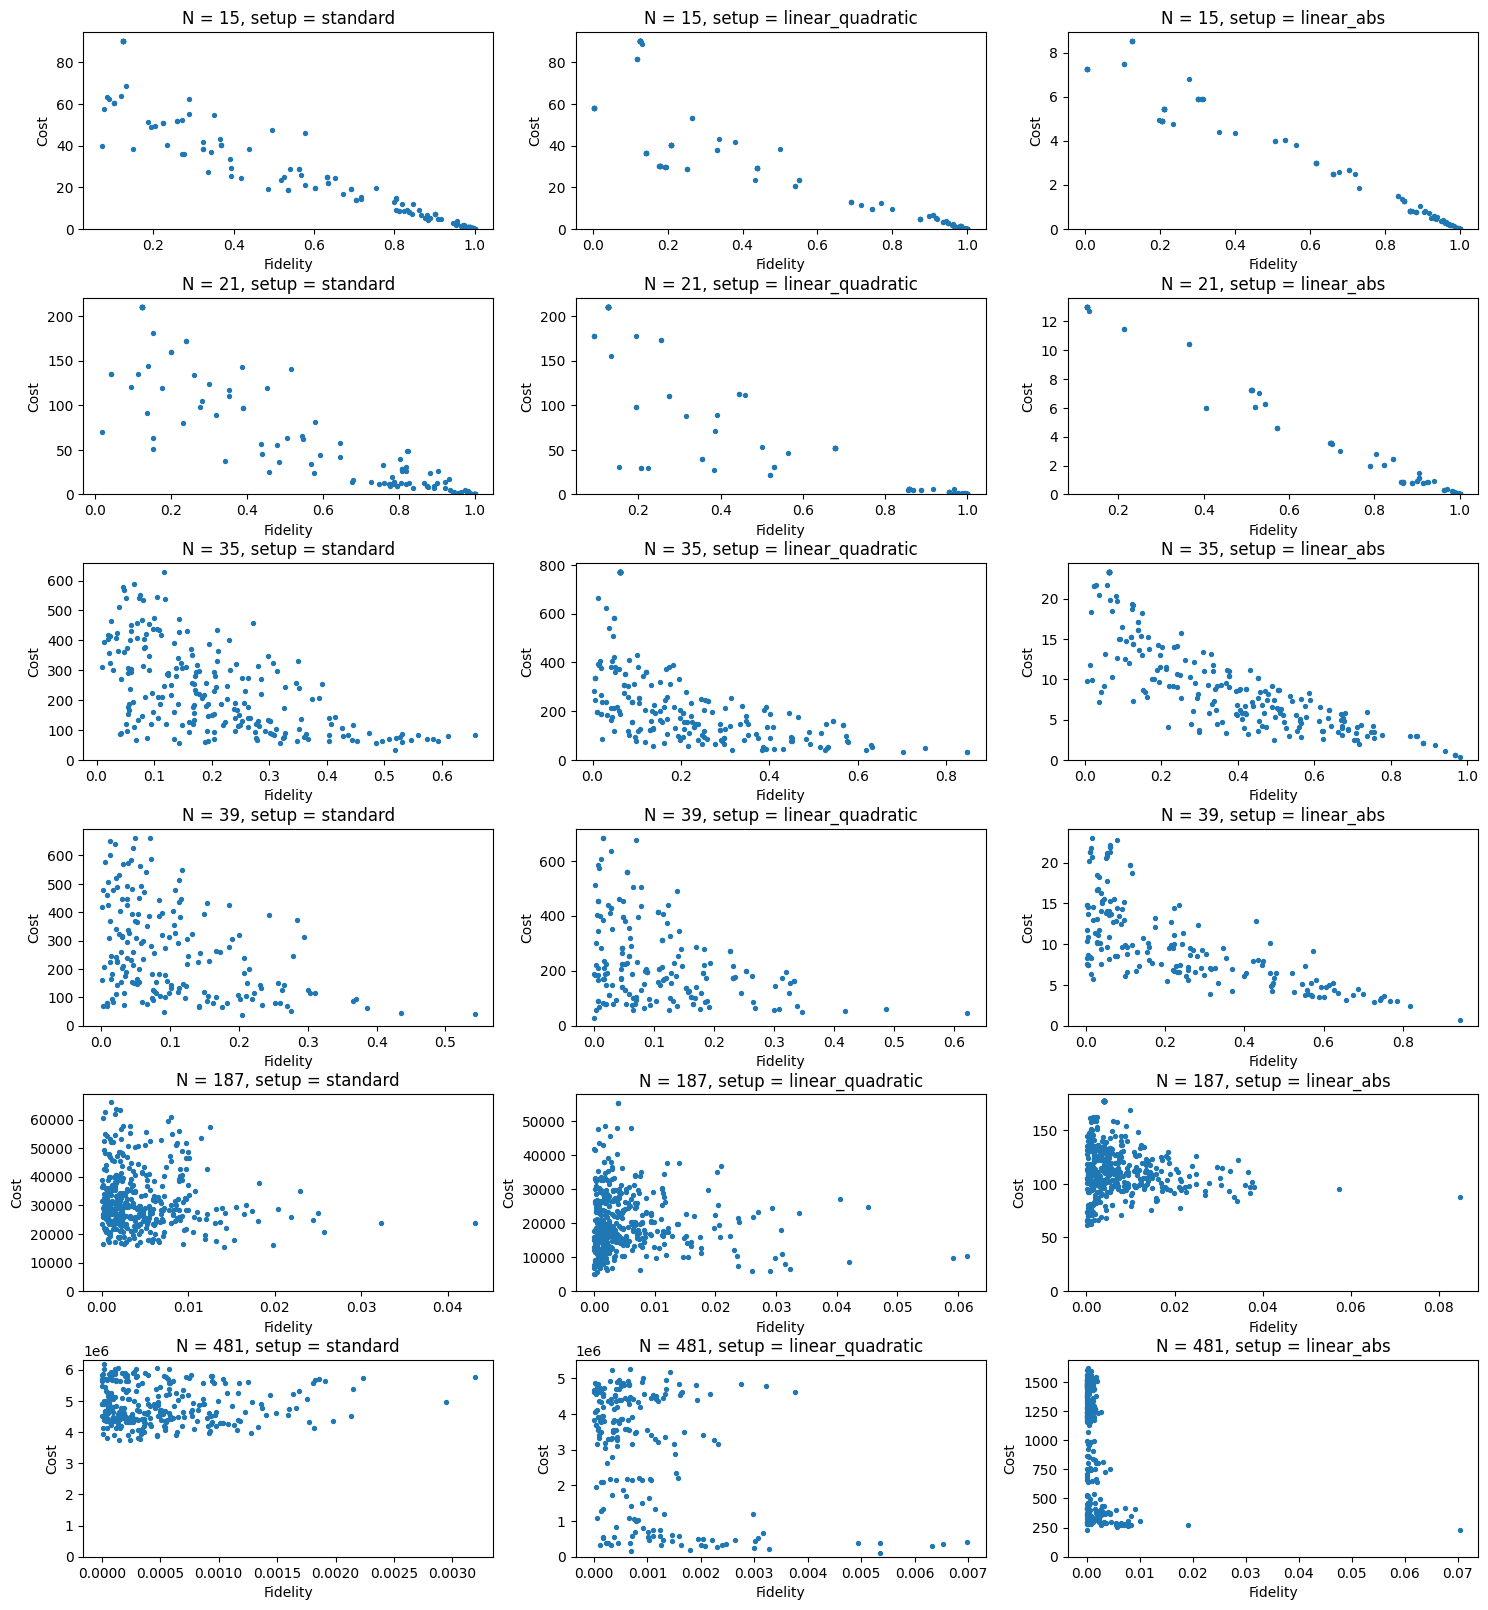

In [14]:
Ns = sorted(experiment_results.N.unique())
setups = sorted(experiment_results.setup.unique(), reverse=True)

fig, axs = plt.subplots(len(Ns), len(setups), figsize=(6*len(setups), 3.3*len(Ns)))
fig.subplots_adjust(hspace=0.35, wspace=0.2)

for i, N in enumerate(Ns):
    df_N = experiment_results[(experiment_results.N == N)].reset_index(drop=True)
    num_qubits = df_N.loc[0, 'num_qubits']

    for j, setup in enumerate(setups):
        df_N_setup = df_N[(df_N['setup']==setup)].reset_index(drop=True)

        scatter_colors = [plot_colors[j][0] if c in solutions else plot_colors[j][1] for c in x_hist]

        axs[i][j].scatter(df_N_setup['fidelity'], df_N_setup['cost'], s=8)
        axs[i][j].set_ylim(0)

        axs[i][j].set_title(f'N = {N}, setup = {setup}')
        axs[i][j].set_ylabel('Cost')
        axs[i][j].set_xlabel('Fidelity')

## Probability distributions

In [24]:
Ns = sorted(experiment_results['N'].unique())
cost_Hs = sorted(experiment_results['cost_hamiltonian'].unique())

dfs = []

for N in Ns:
    for Hc in cost_Hs:
        solver = QAOASolver(N=N, cost_hamiltonian=Hc)
        Ec = [E.real for E in solver.Ec]
        df = pd.DataFrame({
            'N': [N],
            'cost_hamiltonian': [Hc],
            'Ec': [Ec]
        })
        dfs.append(df)

energies_df = pd.concat(dfs, ignore_index=True)
df = experiment_results.merge(energies_df, how='left', on=['N', 'cost_hamiltonian'])

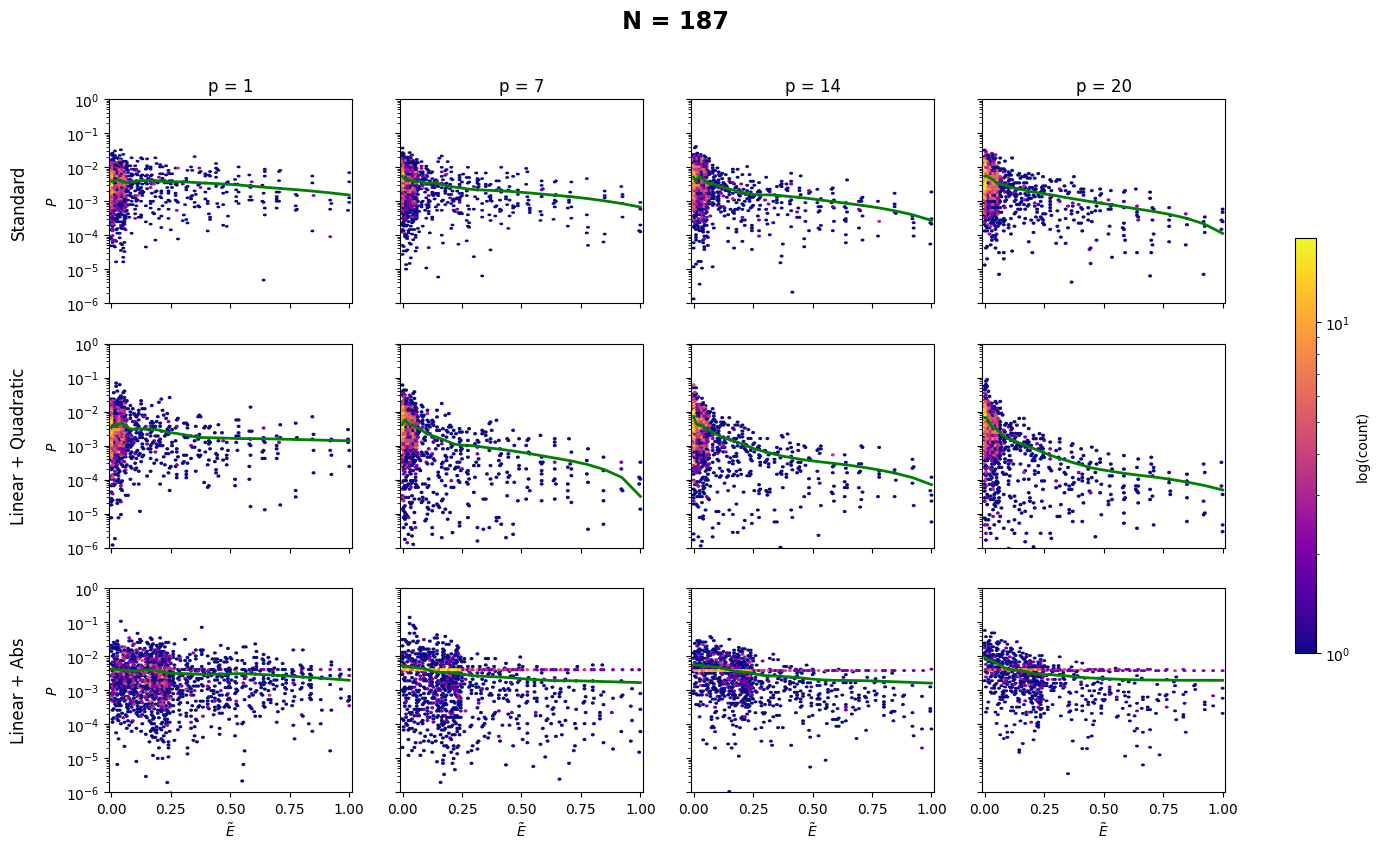

In [25]:
N = 187
optimizer = 'L-BFGS-B'


df_N = df[(df['N']==N) & (df['optimizer']==optimizer)]
layer_min = df_N['layers'].min()
layer_max = df_N.groupby('setup')['layers'].max().min()
n_samples = 4
target_layers = [int(round(x, 0)) for x in np.linspace(layer_min, layer_max, n_samples)]


df_N_target = df_N[df_N['layers'].isin(target_layers)].copy()
df_N_target = df_N.sort_values(by='layers')


nrows = 3
fig, axs = plt.subplots(nrows=3, ncols=n_samples, figsize=(18, 9),sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.2)

for idx_col, p in enumerate(target_layers):
    for idx_row, setup in enumerate(['standard', 'linear_quadratic', 'linear_abs']):
        ax = axs[idx_row][idx_col]
        df_p = df_N_target[(df_N_target['layers']==p) & (df_N_target['setup']==setup)]

        rescaled_energies_all = []
        probs_all = []

        for _, row in df_p.iterrows():
            probs = row['state_populations']
            energies = np.array(row['Ec'])

            E_min = np.min(energies)
            E_max = np.max(energies)
            rescaled_E = (energies - E_min) / (E_max - E_min)

            rescaled_energies_all.extend(rescaled_E)
            probs_all.extend(probs)

        # Plot using hexbin for density
        hb = ax.hexbin(rescaled_energies_all, probs_all,
                       gridsize=100, cmap='plasma', bins='log', yscale='log')
                       
        ax.set_xlim(-0.01,1.01)
        ax.set_ylim(1e-6,1)
        
        if idx_row == 0:
            ax.set_title(f'p = {p}', fontsize='large', fontweight='medium')
        if idx_col == 0:
            ax.set_ylabel('$P$')
        if idx_row == 2:
            ax.set_xlabel('$\\tilde{E}$')

        # Convert to NumPy arrays
        rescaled_energies_all = np.array(rescaled_energies_all)
        probs_all = np.array(probs_all)

        x = sorted(np.unique(rescaled_energies_all))
        y = []

        for e in x:
            idcs = np.where(rescaled_energies_all==e)
            probs = probs_all[idcs]
            y.append(np.average(probs))

        smoothed = lowess(y, x, frac=0.25)
        ax.plot(smoothed[:,0], smoothed[:,1], color='green', linewidth=2)


# Color bar for density
fig.colorbar(hb, ax=axs, label='log(count)', shrink=0.6)

fig.suptitle(f'N = {N}', x=0.41, ha='left', fontsize='xx-large', fontweight='bold')

setup_labels = ['Standard', 'Linear + Quadratic', 'Linear + Abs']
for idx_row, label in enumerate(setup_labels):
    # Get vertical center of any subplot in the row (e.g., first column)
    ax_row = axs[idx_row][0]
    pos = ax_row.get_position()
    y_center = (pos.y0 + pos.y1) / 2

    # Add label to the left of the row
    fig.text(0.08, y_center, label, va='center', ha='right', fontsize='large', fontweight='medium', rotation=90)


plt.show()

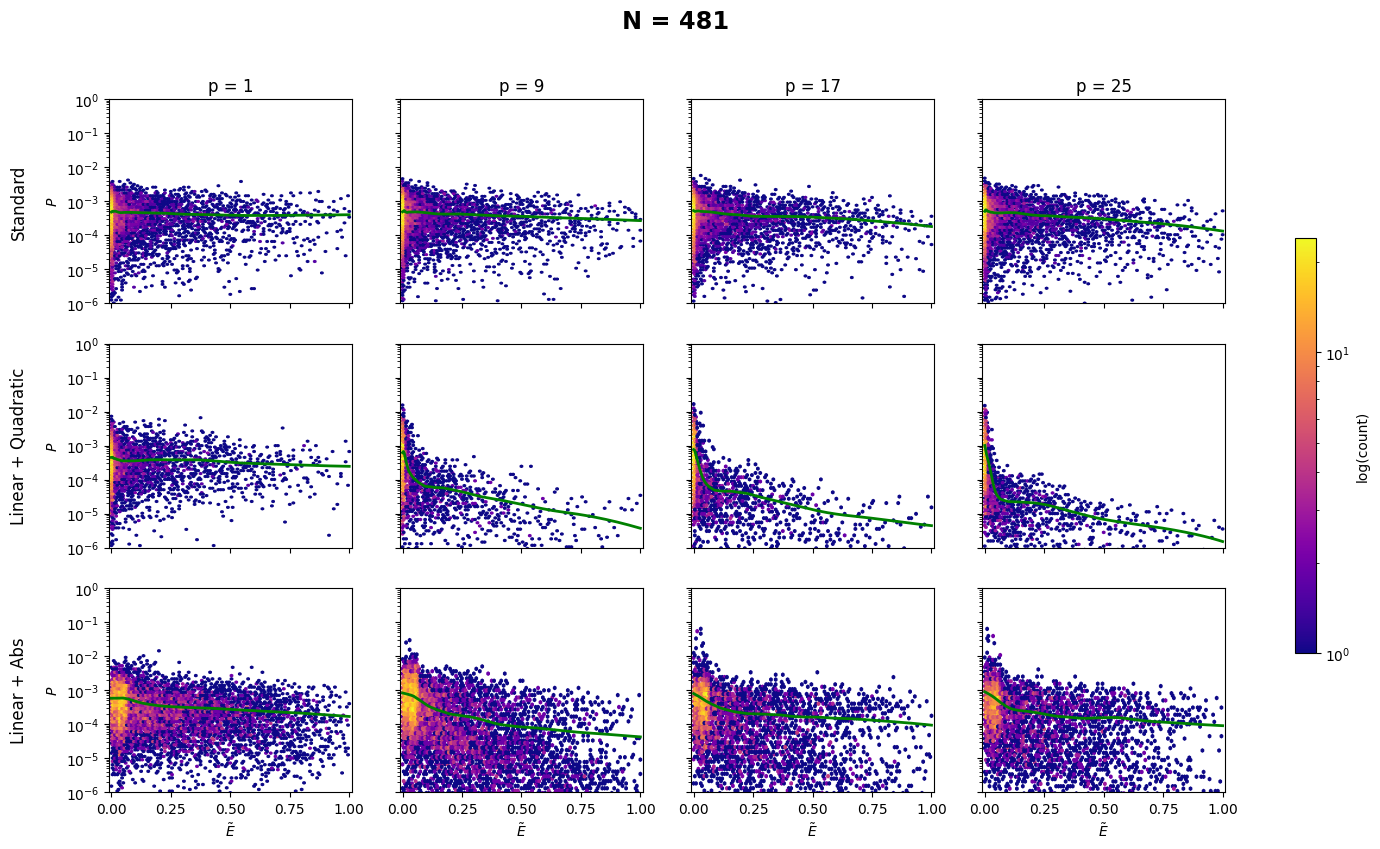

In [26]:
N = 481
optimizer = 'L-BFGS-B'


df_N = df[(df['N']==N) & (df['optimizer']==optimizer)]
layer_min = df_N['layers'].min()
layer_max = df_N.groupby('setup')['layers'].max().min()
n_samples = 4
target_layers = [int(round(x, 0)) for x in np.linspace(layer_min, layer_max, n_samples)]


df_N_target = df_N[df_N['layers'].isin(target_layers)].copy()
df_N_target = df_N.sort_values(by='layers')


nrows = 3
fig, axs = plt.subplots(nrows=3, ncols=n_samples, figsize=(18, 9),sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.2)

for idx_col, p in enumerate(target_layers):
    for idx_row, setup in enumerate(['standard', 'linear_quadratic', 'linear_abs']):
        ax = axs[idx_row][idx_col]
        df_p = df_N_target[(df_N_target['layers']==p) & (df_N_target['setup']==setup)]

        rescaled_energies_all = []
        probs_all = []

        for _, row in df_p.iterrows():
            probs = row['state_populations']
            energies = np.array(row['Ec'])

            E_min = np.min(energies)
            E_max = np.max(energies)
            rescaled_E = (energies - E_min) / (E_max - E_min)

            rescaled_energies_all.extend(rescaled_E)
            probs_all.extend(probs)

        # Plot using hexbin for density
        hb = ax.hexbin(rescaled_energies_all, probs_all,
                       gridsize=100, cmap='plasma', bins='log', yscale='log')
                       
        ax.set_xlim(-0.01,1.01)
        ax.set_ylim(1e-6,1)
        
        if idx_row == 0:
            ax.set_title(f'p = {p}', fontsize='large', fontweight='medium')
        if idx_col == 0:
            ax.set_ylabel('$P$')
        if idx_row == 2:
            ax.set_xlabel('$\\tilde{E}$')

        # Convert to NumPy arrays
        rescaled_energies_all = np.array(rescaled_energies_all)
        probs_all = np.array(probs_all)

        x = sorted(np.unique(rescaled_energies_all))
        y = []

        for e in x:
            idcs = np.where(rescaled_energies_all==e)
            probs = probs_all[idcs]
            y.append(np.average(probs))

        smoothed = lowess(y, x, frac=0.25)
        ax.plot(smoothed[:,0], smoothed[:,1], color='green', linewidth=2)


# Color bar for density
fig.colorbar(hb, ax=axs, label='log(count)', shrink=0.6)

fig.suptitle(f'N = {N}', x=0.41, ha='left', fontsize='xx-large', fontweight='bold')

setup_labels = ['Standard', 'Linear + Quadratic', 'Linear + Abs']
for idx_row, label in enumerate(setup_labels):
    # Get vertical center of any subplot in the row (e.g., first column)
    ax_row = axs[idx_row][0]
    pos = ax_row.get_position()
    y_center = (pos.y0 + pos.y1) / 2

    # Add label to the left of the row
    fig.text(0.08, y_center, label, va='center', ha='right', fontsize='large', fontweight='medium', rotation=90)


plt.show()

## Using same initial parameters

In [17]:
INIT_PARAMS = {
    'a': [2.278194341790279,1.8878746546919813],
    'b': [3.4748376816697872, 2.118867272280805],
    'c': [4.022993274680973, 0.8503996595801566]
}

### L-BFGS-B

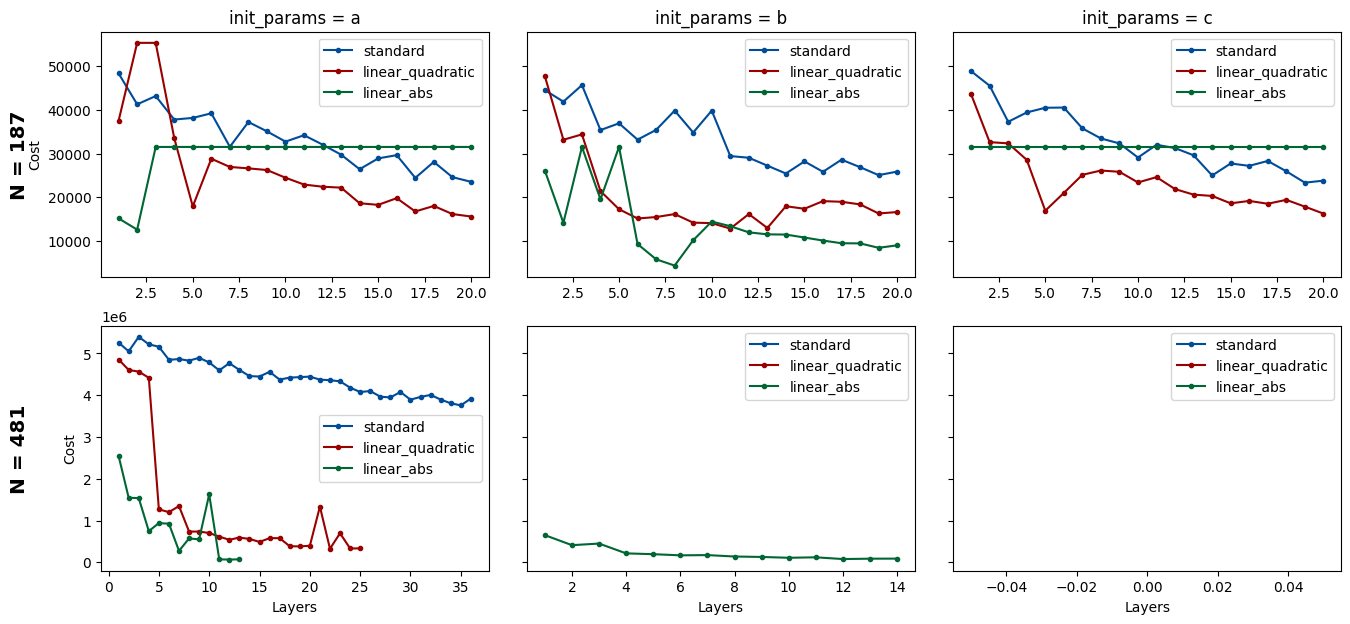

In [18]:
extended_qaoa = False

fig, axs = plt.subplots(2, 3, figsize=(16, 7), sharey='row')
fig.subplots_adjust(wspace=0.1)

for idx_row, N in enumerate([187,481]):
    for idx_col, init_conf in enumerate(['a','b','c']):
        df_N = experiment_results[(experiment_results.N == N) & (experiment_results.optimizer == 'L-BFGS-B')
                                & (experiment_results.extended_qaoa == False)
                                & (experiment_results.angle_interpolation == True)
                                & (experiment_results.gamma_0 == round(INIT_PARAMS[init_conf][0], 3))
                                & (experiment_results.beta_0 == round(INIT_PARAMS[init_conf][1], 3))]
        for j, setup in enumerate(setups):
            df = df_N[df_N.setup == setup].copy()
            if setup == 'linear_abs':
                df['cost'] = np.power(df['cost'], 2)
            ax = axs[idx_row][idx_col]
            ax.plot('layers', 'cost', data=df, marker='.', color=plot_colors[j+1][0], label=setup)
            ax.legend(loc='best')

        if idx_col == 0:
            ax.set_ylabel('Cost')
        if idx_row == 0:
            ax.set_title(f'init_params = {init_conf}')
        if idx_row == 1:
            ax.set_xlabel('Layers')
    

    ax_row = axs[idx_row][0]
    pos = ax_row.get_position()
    y_center = (pos.y0 + pos.y1) / 2
    fig.text(0.08, y_center, f'N = {N}', va='center', ha='right', fontsize='x-large', fontweight='semibold', rotation=90)